In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split

import seaborn as sns

Using TensorFlow backend.


In [3]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, ELU, Add
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator


In [21]:
from sys import platform

In [22]:
from sklearn import preprocessing


In [23]:
if platform == "linux":
    dataDir = "/home/donchan/Documents/myData/KaggleData/Iceberg"
else:
    dataDir = "/Users/donchan/Documents/myData/KaggleData/Iceberg"

In [24]:
import os
train_data = os.path.join(dataDir,"data/processed/train.json")
test_data = os.path.join(dataDir,"data/processed/test.json")


# loading data #

In [25]:
print("load data...")


train = pd.read_json(train_data)
test = pd.read_json(test_data)
#train.inc_angle = train.inc_angle.replace('na', 0)
#train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

load data...
done!


In [12]:
angle = train.inc_angle.copy()
angle = angle.replace('na',np.nan)

In [19]:
angle_median = angle.median()
angle_mean = angle.mean()
angle = angle.astype(np.float32).fillna(angle_median)

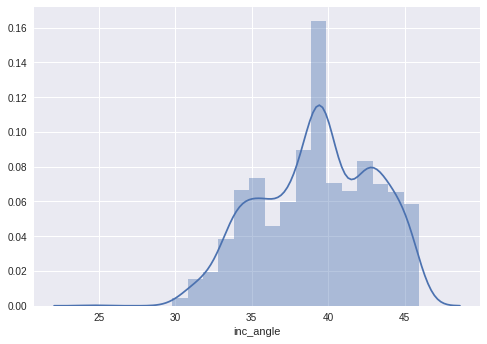

In [20]:
sns.distplot(angle)

In [27]:
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

x1_shape = x_band1.shape
x2_shape = x_band2.shape

scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
stand_x_band1 = mm_scaler.fit_transform(x_band1.reshape(-1,1))
stand_x_band2 = mm_scaler.fit_transform(x_band2.reshape(-1,1))
x_band1_st = stand_x_band1.reshape(x1_shape)
x_band2_st = stand_x_band2.reshape(x2_shape)


In [13]:
x_band1.shape,x_band2.shape,x_band1_st.shape,x_band2_st.shape

((1604, 75, 75), (1604, 75, 75), (1604, 75, 75), (1604, 75, 75))

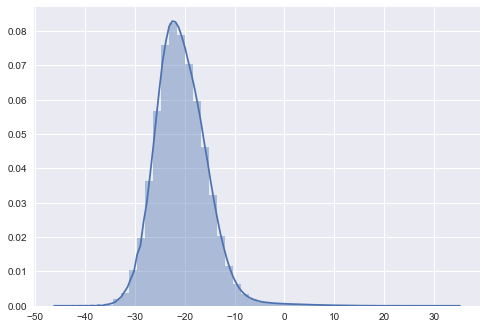

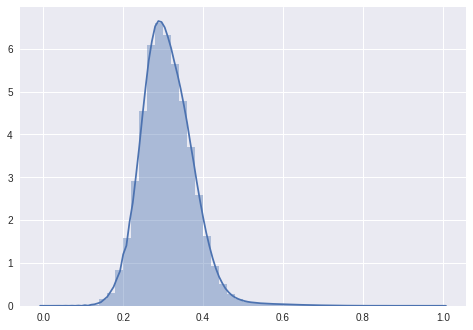

In [14]:
sns.distplot(stand_x_band1)

In [28]:
X_train = np.concatenate([x_band1_st[:, :, :, np.newaxis]
                          , x_band2_st[:, :, :, np.newaxis]
                         , ((x_band1_st+x_band1_st)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])





In [16]:
np.corrcoef(X_angle_train,y_train)

array([[ 1.        ,  0.26628294],
       [ 0.26628294,  1.        ]])

# One hot code y_train #

In [29]:
oh = preprocessing.OneHotEncoder(sparse=False)
y_train_oh = oh.fit_transform( y_train[:,np.newaxis])


In [30]:
y_train_oh[:10]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [31]:
y_train[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [38]:
np.arange(12).reshape(3,4).mean(axis=1)

array([ 1.5,  5.5,  9.5])

# Split Training and Validation #

In [18]:
x_train, x_valid, y_train_oh, y_valid_oh = train_test_split(X_train, y_train_oh, test_size=0.2, random_state=42)

In [19]:
x_train.shape, x_valid.shape, y_train_oh.shape, y_valid_oh.shape

((1283, 75, 75, 3), (321, 75, 75, 3), (1283, 2), (321, 2))

In [20]:
train["is_iceberg"].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

# Keras Model Definiton #

In [45]:
def get_model(p_activation="elu", k_size = (5,5), dropout=0.25):
    bn_model = 0.99
    #p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(dropout)(img_1)

    img_1 = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_1))
    img_1 = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")(img_1)
    img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = Dropout(dropout)(img_1)    
    
    print("img1 shape", img_1.shape)

    img_resid = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_1))
    img_resid = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")(img_resid)
    img_resid = Dropout(dropout)(img_resid)    
    print("img_resid shape1", img_resid.shape)
    
    img_resid = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_resid))
    img_resid = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")(img_resid)
    print("img_resid shape2", img_resid.shape)

    cnn_resid_added = Add()([img_1, img_resid])
    print("cnn_resid shape", cnn_resid_added.shape)
    
    top_cnn = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(cnn_resid_added))
    top_cnn = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    top_cnn = Conv2D(256, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(top_cnn))
    top_cnn = Conv2D(256, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = Dropout(0.25)(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    top_cnn = Conv2D(512, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(top_cnn))
    top_cnn = Conv2D(512, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = Dropout(dropout)(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    
    top_cnn = GlobalMaxPooling2D()(top_cnn)
    print("top_cnn shape", top_cnn.shape)

    dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(512, activation=None)(top_cnn) ))
    dense_ayer = Dropout(0.5)(dense_ayer)
    dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(256, activation=None)(dense_ayer) ))
    dense_ayer = Dropout(0.5)(dense_ayer)
    
    # 2 for One Hot code for Binary 
    output = Dense(2, activation="softmax")(dense_ayer)
    
    
    
    model = Model([input_1],  output)
    #optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    optimizer = Adam(lr=0.001)
    
    #model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    #model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    
    return model


In [51]:
model = get_model(dropout=0.5,k_size=(3,3))
model.summary()

img1 shape (?, 18, 18, 64)
img_resid shape1 (?, 18, 18, 128)
img_resid shape2 (?, 18, 18, 64)
cnn_resid shape (?, 18, 18, 64)
top_cnn shape (?, 512)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_658 (BatchNo (None, 75, 75, 3)     12          X_1[0][0]                        
____________________________________________________________________________________________________
conv2d_1023 (Conv2D)             (None, 75, 75, 32)    896         batch_normalization_658[0][0]    
____________________________________________________________________________________________________
conv2d_1024 (Conv2D)             (None, 75,

# training parameters #

In [55]:
batch_size = 32
epochs = 50 ## change this to 80
#steps_per_epoch=np.power(2,14) /batch_size ## change to 2^14

#print(steps_per_epoch)

# Callback definition #

In [56]:
def get_callbacks(filepath, patience=10):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "keras_model2_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [57]:
gen_images = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,)
        #fill_mode='nearest')

model.fit_generator(
    
        gen_images.flow(x_train,y_train_oh,batch_size=batch_size),
        steps_per_epoch=np.ceil(32.0 * float(y_train_oh.shape[0]) / float(batch_size)),
        epochs=epochs,
        validation_data=(x_valid,y_valid_oh),
        validation_steps=np.ceil(32.0 * float(y_valid_oh.shape[0]) / float(batch_size)), 
        callbacks=callbacks)

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[32,75,75,32]
	 [[Node: conv2d_1023/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](batch_normalization_658/cond/Merge, conv2d_1023/kernel/read)]]
	 [[Node: loss_73/mul/_21137 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_7073_loss_73/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_1023/convolution', defined at:
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-cea55d126f84>", line 1, in <module>
    model = get_model(dropout=0.5,k_size=(3,3))
  File "<ipython-input-45-86bf7e30ed38>", line 7, in get_model
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") ((BatchNormalization(momentum=bn_model))(input_1))
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3164, in conv2d
    data_format='NHWC')
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,75,75,32]
	 [[Node: conv2d_1023/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](batch_normalization_658/cond/Merge, conv2d_1023/kernel/read)]]
	 [[Node: loss_73/mul/_21137 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_7073_loss_73/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [27]:
model.load_weights(filepath=file_path)
score = model.evaluate(x_valid, y_valid_oh, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


320/321 [============================>.] - ETA: 0sTest loss: 0.26210459931
Test accuracy: 0.890965732087


In [40]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)







#x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
#x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
#                          , x_band2[:, :, :, np.newaxis]
#                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)


In [50]:
prediction = model.predict([X_test], verbose=1, batch_size=200)

8400/8424 [============================>.] - ETA: 0s

In [53]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction[:,1]})

In [54]:
submission.head()

,id,is_iceberg
0,5941774d,0.695578
1,4023181e,0.113909
2,b20200e4,0.000026
3,e7f018bb,0.966803
4,4371c8c3,0.020416


In [55]:
submission.to_csv("output/keras_model2_basic.csv",index=False)

# test for Cross Validation #

In [35]:
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


In [32]:
y_onehot = np_utils.to_categorical( y_train )
num_classes = y_onehot.shape[1]

In [47]:
p_activation = ["elu","relu", "sigmoid"]
k_size = [(3,3), (5,5)]
dropout = [0.25, 0.50, 0.75 ]
nb_epoch = [10, 25, 50]
batch_size = [16, 32, 64]


In [49]:
model = KerasClassifier(build_fn=get_model, verbose=1)
param_grid = dict(p_activation=p_activation, 
                  k_size=k_size, 
                  dropout=dropout, 
                  nb_epoch=nb_epoch, 
                  batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid)


In [ ]:


input_CNN = input_img_norm %>%
    layer_conv_2d(32, kernel_size = kernel_size,padding = "same") %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_max_pooling_2d(c(2,2)) %>%
    layer_dropout(0.25) %>%
    layer_conv_2d(64, kernel_size = kernel_size,padding = "same") %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_max_pooling_2d(c(2,2)) %>%
    layer_dropout(0.25) 

## first residual
input_CNN_residual = input_CNN %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_conv_2d(128, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_conv_2d(64, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu()

input_CNN_residual = layer_add(list(input_CNN_residual,input_CNN))

top_CNN = input_CNN_residual %>%
  layer_conv_2d(128, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_conv_2d(256, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_conv_2d(512, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_global_max_pooling_2d()

outputs = top_CNN %>%
    layer_dense(512,activation = NULL) %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_dropout(0.5) %>%
    layer_dense(256,activation = NULL) %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_dropout(0.5) %>%
    layer_dense(2,activation = "softmax") ## not sure using softmax is the right thing to do...
    
model <- keras_model(inputs = list(input_img), outputs = list(outputs))

model %>% compile(optimizer=optimizer_adam(lr = 0.001),
                  loss="binary_crossentropy",
                  metrics = c("accuracy"))

summary(model)